# Import Package

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf

import math
import datetime
import requests
import io
import base64
import locale

# Read Data

In [3]:
data = pd.read_excel('ready_data_pax_bms 1 April - 19 Juli 2023.xlsx', index_col='Unnamed: 0')
data

,DATE,PAX_BMS_T1,PAX_BMS_T2,PAX_BMS_T3
0,2023-04-01 00:00:00,0,8,0
1,2023-04-01 01:00:00,0,0,0
2,2023-04-01 02:00:00,0,0,0
3,2023-04-01 03:00:00,0,0,0
4,2023-04-01 04:00:00,0,0,0
...,...,...,...,...
2635,2023-07-19 19:00:00,73,119,65
2636,2023-07-19 20:00:00,69,92,90
2637,2023-07-19 21:00:00,28,25,47
2638,2023-07-19 22:00:00,2,9,31


In [5]:
data_paxT3 = data[['DATE', 'PAX_BMS_T3']]
data_paxT3

,DATE,PAX_BMS_T3
0,2023-04-01 00:00:00,0
1,2023-04-01 01:00:00,0
2,2023-04-01 02:00:00,0
3,2023-04-01 03:00:00,0
4,2023-04-01 04:00:00,0
...,...,...
2635,2023-07-19 19:00:00,65
2636,2023-07-19 20:00:00,90
2637,2023-07-19 21:00:00,47
2638,2023-07-19 22:00:00,31


In [11]:
from statistics import stdev

def Average(data):
    return sum(data) / len(data)

def convert_bit_lenght(data):        
    a = []
    for element in data:
        native_int = int(element)
        a.append(native_int.bit_length())
    return a

def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

In [12]:
paxT3 = data_paxT3['PAX_BMS_T3'].values[-48:-24]

paxT3_scaled = normalize_series(paxT3, Average(paxT3), stdev(convert_bit_lenght(paxT3)))
paxT3_scaled

array([-17.07036288, -18.20838707, -18.20838707, -18.20838707,
       -18.20838707, -15.55299729, -11.75958332,  -3.41407258,
        -4.55209677,  -6.06946236,   4.93143817,  27.691922  ,
        11.38024192,   2.27604838,  13.27694891,  12.13892471,
        16.69102148,  23.13982524,  10.24221773,  11.00090052,
        17.44970428,   3.03473118,  -5.31077956, -16.69102148])

# Read Model

In [13]:
model = tf.keras.models.load_model('./model v2/BidirectionalGRU-Model.h5')

In [14]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [22]:
_forecast_train_data = model_forecast(model, paxT3_scaled, 24, 1)
print(_forecast_train_data.shape)

forecast_train_data = _forecast_train_data[0]
print(forecast_train_data.shape)
print(paxT3_scaled.shape[0])

      1/Unknown - 0s 24ms/step

1/1 [==============================] - 0s 59ms/step
(1, 24)
(24,)
24


In [23]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(paxT3), stdev(convert_bit_lenght(paxT3)))
forecast_train_data[:5]

array([ 0.4788437 , -1.4779701 , -4.139881  ,  0.28588486,  0.88230896],
      dtype=float32)

In [30]:
# actual = np.squeeze(paxT3[-forecast_train_data.shape[0]:])
# data_paxT3['PAX_BMS_T3'].values[-48:-24]

actual = np.squeeze(data_paxT3['PAX_BMS_T3'].values[-24:])
print(actual.shape)
print(actual[:5])

(24,)
[2 0 0 0 0]


In [31]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data[-forecast_train_data.shape[0]:]['DATE']
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

,Date,Actual,Forecast
2616,2023-07-19 00:00:00,2,0.478844
2617,2023-07-19 01:00:00,0,-1.477970
2618,2023-07-19 02:00:00,0,-4.139881
2619,2023-07-19 03:00:00,0,0.285885
2620,2023-07-19 04:00:00,0,0.882309
2621,2023-07-19 05:00:00,1,5.539051
2622,2023-07-19 06:00:00,6,20.136045
2623,2023-07-19 07:00:00,24,33.634338
2624,2023-07-19 08:00:00,50,44.096935
2625,2023-07-19 09:00:00,95,59.937019


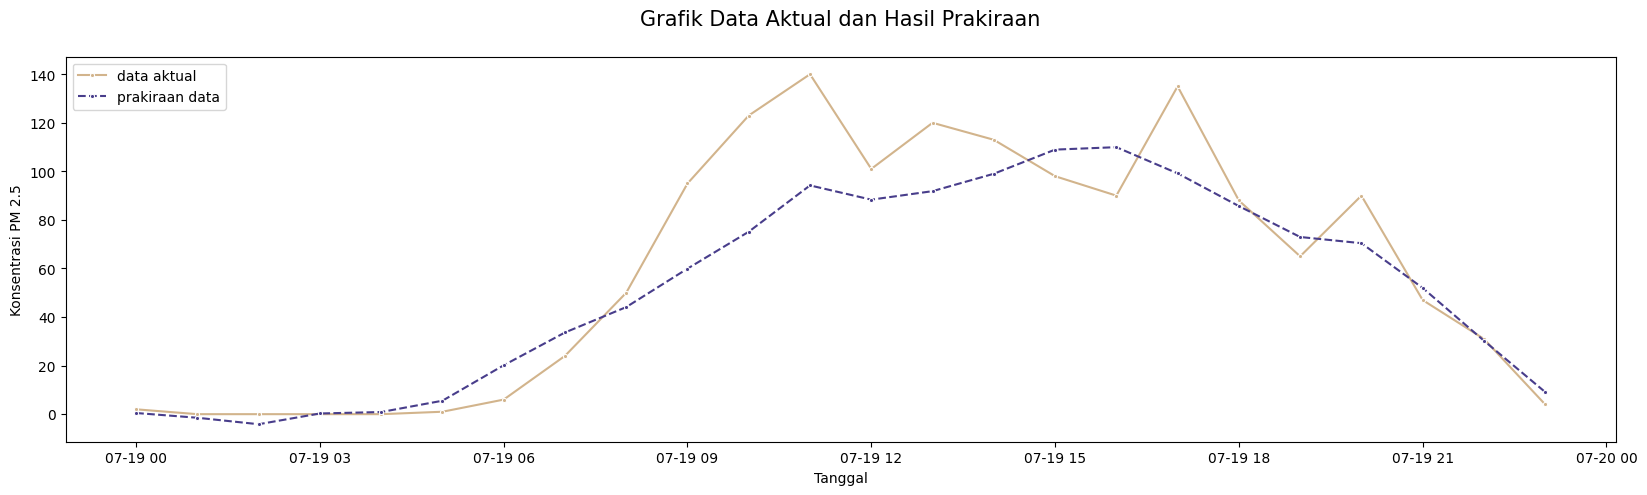

In [34]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 15)
plt.legend(loc='upper left')

In [35]:
import plotly.express as px

df = px.data.stocks()
fig = px.line(df_train[-24:], x="Date", y=['Actual', 'Forecast'],
            #   hover_data={"Date": "|%B %d, %Y"},
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()